# Cox-Ross-Rubinstein Binomial Tree Structure for Discrete Option Pricing

Binomial tree with display_mode=3 saved as 'binomial_tree_flexible_display.png'
The price of the option at t=0 is: 16.8630


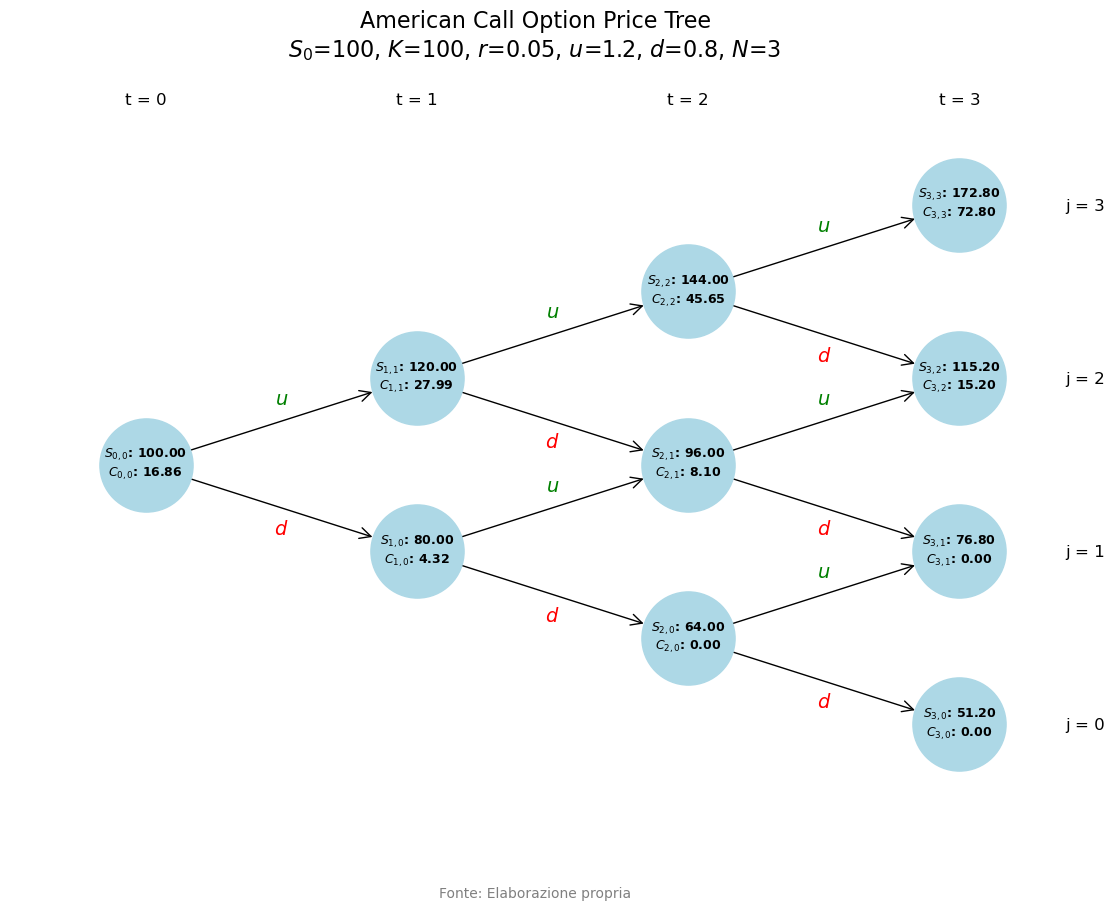

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# --- 1. Define Model Parameters ---

# *** NEW: Set display mode ***
# 1 = Simple (S_t,j)
# 2 = Stock Price (S_t,j \n $Price)
# 3 = Full (S_t,j: $Price \n C_t,j: $Value)
display_mode = 3 # <-- CHANGE THIS VALUE TO HIDE/SHOW DETAILS

# --- Model Parameters ---
N = 3      # Number of steps
S0 = 100   # Initial stock price
u = 1.2    # Up-factor
d = 0.8    # Down-factor

# --- Option Parameters ---
K = 100    # Strike price
T = 1.0    # Time to maturity
r = 0.05   # Risk-free rate
option_type = 'call' 

# --- 1.5 Calculate Intermediate Values ---
dt = T / N  
p = (math.exp(r * dt) - d) / (u - d) 
discount_factor = math.exp(-r * dt)     

# --- 2. Create a directed graph ---
G = nx.DiGraph()

# --- 3. Dictionaries for positions and labels ---
pos = {}

# --- 4. Add nodes and store price data ---
for t in range(N + 1):
    for j in range(t + 1):  
        node = (t, j)
        price = S0 * (u**j) * (d**(t-j)) 
        pos[node] = (t, 2*j - t) 
        G.add_node(node, price=price, option_value=0.0)

# --- 5. Add edges ---
for t in range(N):
    for j in range(t + 1):
        G.add_edge((t, j), (t + 1, j + 1)) # Up
        G.add_edge((t, j), (t + 1, j))     # Down

# --- 6. Backward Induction for Option Pricing ---
# 6.1: Calculate payoff at terminal nodes (t=N)
for j in range(N + 1):
    node = (N, j)
    S = G.nodes[node]['price']
    if option_type == 'call':
        payoff = max(0, S - K)
    else: 
        payoff = max(0, K - S)
    G.nodes[node]['option_value'] = payoff

# 6.2: Work backwards from t=N-1 to t=0
for t in range(N - 1, -1, -1): 
    for j in range(t + 1):
        node = (t, j)
        value_up = G.nodes[(t + 1, j + 1)]['option_value']
        value_down = G.nodes[(t + 1, j)]['option_value']
        
        expected_value = (p * value_up) + ((1 - p) * value_down)
        discounted_value = expected_value * discount_factor
        
        S = G.nodes[node]['price']
        if option_type == 'call':
            intrinsic_value = max(0, S - K)
        else: 
            intrinsic_value = max(0, K - S)
            
        G.nodes[node]['option_value'] = max(discounted_value, intrinsic_value)

# --- 7. Create Final Node Labels (Based on display_mode) ---
labels = {}
label_char = 'C' if option_type == 'call' else 'P' 

for node in G.nodes():
    
    if display_mode == 1:
        # Mode 1: Simple (S_t,j)
        labels[node] = f'$S_{{{node[0]},{node[1]}}}$'
        
    elif display_mode == 2:
        # Mode 2: Stock Price
        price = G.nodes[node]['price']
        labels[node] = (f'$S_{{{node[0]},{node[1]}}}$\n'
                        f'${price:.2f}')
    else:
        # Mode 3: Full (Default)
        price = G.nodes[node]['price']
        option_val = G.nodes[node]['option_value']
        labels[node] = (f'$S_{{{node[0]},{node[1]}}}$: {price:.2f}\n'
                        f'${label_char}_{{{node[0]},{node[1]}}}$: {option_val:.2f}')

# --- 8. Set up the figure and main axis ---
fig, ax = plt.subplots(figsize=(14, 9))

# --- 9. Draw the graph (with conditional formatting) ---
if display_mode == 1:
    node_size = 2500
    font_size = 12
elif display_mode == 2:
    node_size = 3500
    font_size = 10
else:
    node_size = 4500
    font_size = 9

nx.draw(G, pos, 
        ax=ax,
        labels=labels,
        node_color='lightblue',
        node_size=node_size,
        font_size=font_size,
        font_weight='bold',
        arrows=True,
        arrowstyle='->',
        arrowsize=20,
        )

# Draw manual u, d arrow edge labels
vertical_offset = 0.25 
for t in range(N):
    for j in range(t + 1):
        pos_from = pos[(t, j)]
        pos_to_up = pos[(t + 1, j + 1)]
        mid_x_up = (pos_from[0] + pos_to_up[0]) / 2
        mid_y_up = (pos_from[1] + pos_to_up[1]) / 2
        ax.text(mid_x_up, mid_y_up + vertical_offset, '$u$', 
                fontsize=14, ha='center', va='center', color='green')
        
        pos_to_down = pos[(t + 1, j)]
        mid_x_down = (pos_from[0] + pos_to_down[0]) / 2
        mid_y_down = (pos_from[1] + pos_to_down[1]) / 2
        ax.text(mid_x_down, mid_y_down - vertical_offset, '$d$', 
                fontsize=14, ha='center', va='center', color='red')

# --- 10. Set title on the main figure ---
# *** THIS LOGIC IS NOW UPDATED ***
if display_mode == 1:
    # --- MODIFICA QUI --- (Titolo aggiornato in italiano)
    title_text = f'Figura 1: Albero Binomiale Struttura a (N={N}) Passi'
elif display_mode == 2:
    title_text = f'Binomial Price Tree (N={N}, $S_0$={S0}, u={u}, d={d})'
else: # display_mode == 3
    title_text = (f'American {option_type.capitalize()} Option Price Tree\n'
                  f'$S_0$={S0}, $K$={K}, $r$={r}, $u$={u}, $d$={d}, $N$={N}')
    
fig.suptitle(title_text, fontsize=16, y=1.00) 

# --- 11. Customize the axes ---
ax.set_xlim(-0.5, N + 0.5)
ax.set_ylim(-N - 1, N + 1) 
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# --- 12. Create TOP axis for 't' labels ---
ax_top = ax.twiny() 
ax_top.set_xlim(ax.get_xlim()) 
ax_top.set_xticks(range(N + 1)) 
ax_top.set_xticklabels([f"t = {t}" for t in range(N + 1)], fontsize=12)
ax_top.tick_params(top=False, labeltop=True, bottom=False, labelbottom=False, left=False, right=False, labelleft=False, labelright=False) 
ax_top.spines['top'].set_visible(False) 
ax_top.spines['right'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.spines['left'].set_visible(False)

# --- 13. Create RIGHT axis for 'j' labels ---
ax_right = ax.twinx() 
ax_right.set_ylim(ax.get_ylim()) 

y_ticks = [2*j - N for j in range(N + 1)] 
y_labels = [f"j = {j}" for j in range(N + 1)] 

ax_right.set_yticks(y_ticks)
ax_right.set_yticklabels(y_labels, fontsize=12)
ax_right.tick_params(top=False, labeltop=False, bottom=False, labelbottom=False, 
                       left=False, right=False, labelleft=False, labelright=True, 
                       pad=-25) 
ax_right.spines['top'].set_visible(False) 
ax_right.spines['right'].set_visible(False)
ax_right.spines['bottom'].set_visible(False)
ax_right.spines['left'].set_visible(False)

# --- 14. Add Footer and Save the plot ---

# --- NUOVA AGGIUNTA QUI ---
# Aggiunge il testo "Fonte: Elaborazione propria" in basso al centro
fig.text(0.5, 0.01, 'Fonte: Elaborazione propria', 
         ha='center', va='bottom', fontsize=10, color='gray')

# Salva l'immagine, bbox_inches='tight' assicura che il footer sia incluso
fig.savefig('binomial_tree_flexible_display.png', bbox_inches='tight')

print(f"Binomial tree with display_mode={display_mode} saved as 'binomial_tree_flexible_display.png'")
if display_mode == 3:
    print(f"The price of the option at t=0 is: {G.nodes[(0, 0)]['option_value']:.4f}")

# Ricorsive algorithm by Rubinstein to calculate Implied Binomial Tree

Grafico del passo di ricorsione salvato come 'ricorsione_IBT.png'


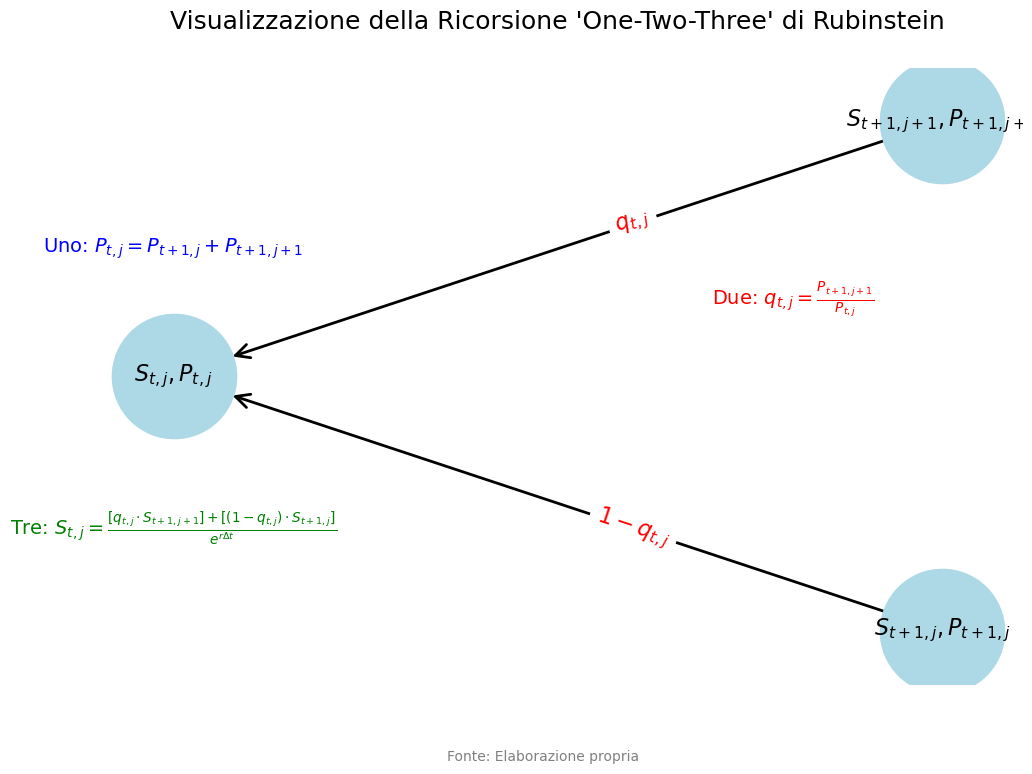

In [42]:
import networkx as nx
import matplotlib.pyplot as plt
import math

# --- 1. Creare un grafo diretto ---
G = nx.DiGraph()

# --- 2. Aggiungere i 3 nodi chiave della ricorsione ---
# (t,j) -> Il nodo corrente che stiamo calcolando
# (t+1, j+1) -> Il nodo futuro "up"
# (t+1, j) -> Il nodo futuro "down"
G.add_node("current", label=r'$S_{t,j}, P_{t,j}$')
G.add_node("future_up", label=r'$S_{t+1,j+1}, P_{t+1,j+1}$')
G.add_node("future_down", label=r'$S_{t+1,j}, P_{t+1,j}$')

# --- 3. Aggiungere gli archi (che puntano all'indietro per la ricorsione) ---
G.add_edge("future_up", "current")
G.add_edge("future_down", "current")

# --- 4. Definire le posizioni dei nodi ---
pos = {
    "current": (0, 0),
    "future_up": (1, 1),
    "future_down": (1, -1)
}

# --- 5. Definire le etichette per gli archi (le probabilità locali) ---
edge_labels = {
    ("future_up", "current"): r'$q_{t,j}$',
    ("future_down", "current"): r'$1 - q_{t,j}$'
}

# --- 6. Creare la figura ---
fig, ax = plt.subplots(figsize=(12, 8))

# Disegnare i nodi
nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue', node_size=8000)

# Disegnare le etichette dei nodi (con la nostra notazione rigorosa)
labels = nx.get_node_attributes(G, 'label')
nx.draw_networkx_labels(G, pos, labels=labels, ax=ax, font_size=16)

# Disegnare gli archi (frecce)
nx.draw_networkx_edges(G, pos, ax=ax,
                       node_size=8000,
                       arrowstyle='->',
                       arrowsize=25,
                       width=2.0)

# Disegnare le etichette degli archi (probabilità)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_size=16,
                             label_pos=0.4, # Posiziona l'etichetta a metà dell'arco
                             font_color='red')

# --- 7. Aggiungere le annotazioni "Uno-Due-Tre" ---
# Testo per il Passaggio "Uno" (Calcolo P_t,j)
ax.text(0, 0.5, r'Uno: $P_{t,j} = P_{t+1,j} + P_{t+1,j+1}$',
        ha='center', va='center', fontsize=14, color='blue')

# Testo per il Passaggio "Due" (Calcolo q_t,j)
ax.text(0.7, 0.3, r'Due: $q_{t,j} = \frac{P_{t+1,j+1}}{P_{t,j}}$',
        ha='left', va='center', fontsize=14, color='red')

# Testo per il Passaggio "Tre" (Calcolo S_t,j)
ax.text(0, -0.6, r'Tre: $S_{t,j} = \frac{ [q_{t,j} \cdot S_{t+1,j+1}] + [(1-q_{t,j}) \cdot S_{t+1,j}] }{e^{r\Delta t}}$',
        ha='center', va='center', fontsize=14, color='green')


# --- 8. Pulizia e Titolo ---
ax.axis('off') # Nasconde gli assi
ax.set_title("Visualizzazione della Ricorsione 'One-Two-Three' di Rubinstein", fontsize=18, y=1.05)
fig.text(0.5, 0.01, 'Fonte: Elaborazione propria', 
         ha='center', va='bottom', fontsize=10, color='gray')

# --- 9. Salvare l'immagine ---
fig.savefig('ricorsione_IBT.png', bbox_inches='tight')

print("Grafico del passo di ricorsione salvato come 'ricorsione_IBT.png'")